# Boosting

На примерах урока мы увидели, что алгоритм XGBoost работает лучше и быстрее относительно GradientBoosting и AdaBoost. Поэтому в этом домашнем задании предлагаем посмотреть, какие еще интересные методы существуют в библиотеке для реализацией этого алгоритма.

### Важность признаков

Признаки, которые используют для обучения модели, оказывают большое влияние на ее качество. Неинформативные или слабо информативные признаки могут существенно понизить эффективность модели.

Отбор признаков – процесс выбора признаков, имеющих наиболее тесные взаимосвязи с целевой переменной. Он позволяет:
- уменьшить переобучение: чем меньше избыточных данных, тем меньше возможностей для модели принимать решения на основе «шума»
- повысить точность: чем меньше противоречивых данных, тем выше точность
- сократить время обучения: чем меньше данных, тем быстрее обучается модель

В библиотеке sckit-learn есть раздел feature_selection, который помогает автоматизировать этот процесс на основе методов статистики, линейной алгебры и некоторых специальных алгоритмов, таких как уже знакомый нам PCA - метод главных компонент.

Некоторые из таких методов реализованы в библиотеках для конкретных алгоритмов, к которым относится и xgboost.

Сгенерируем синтетические данные. 

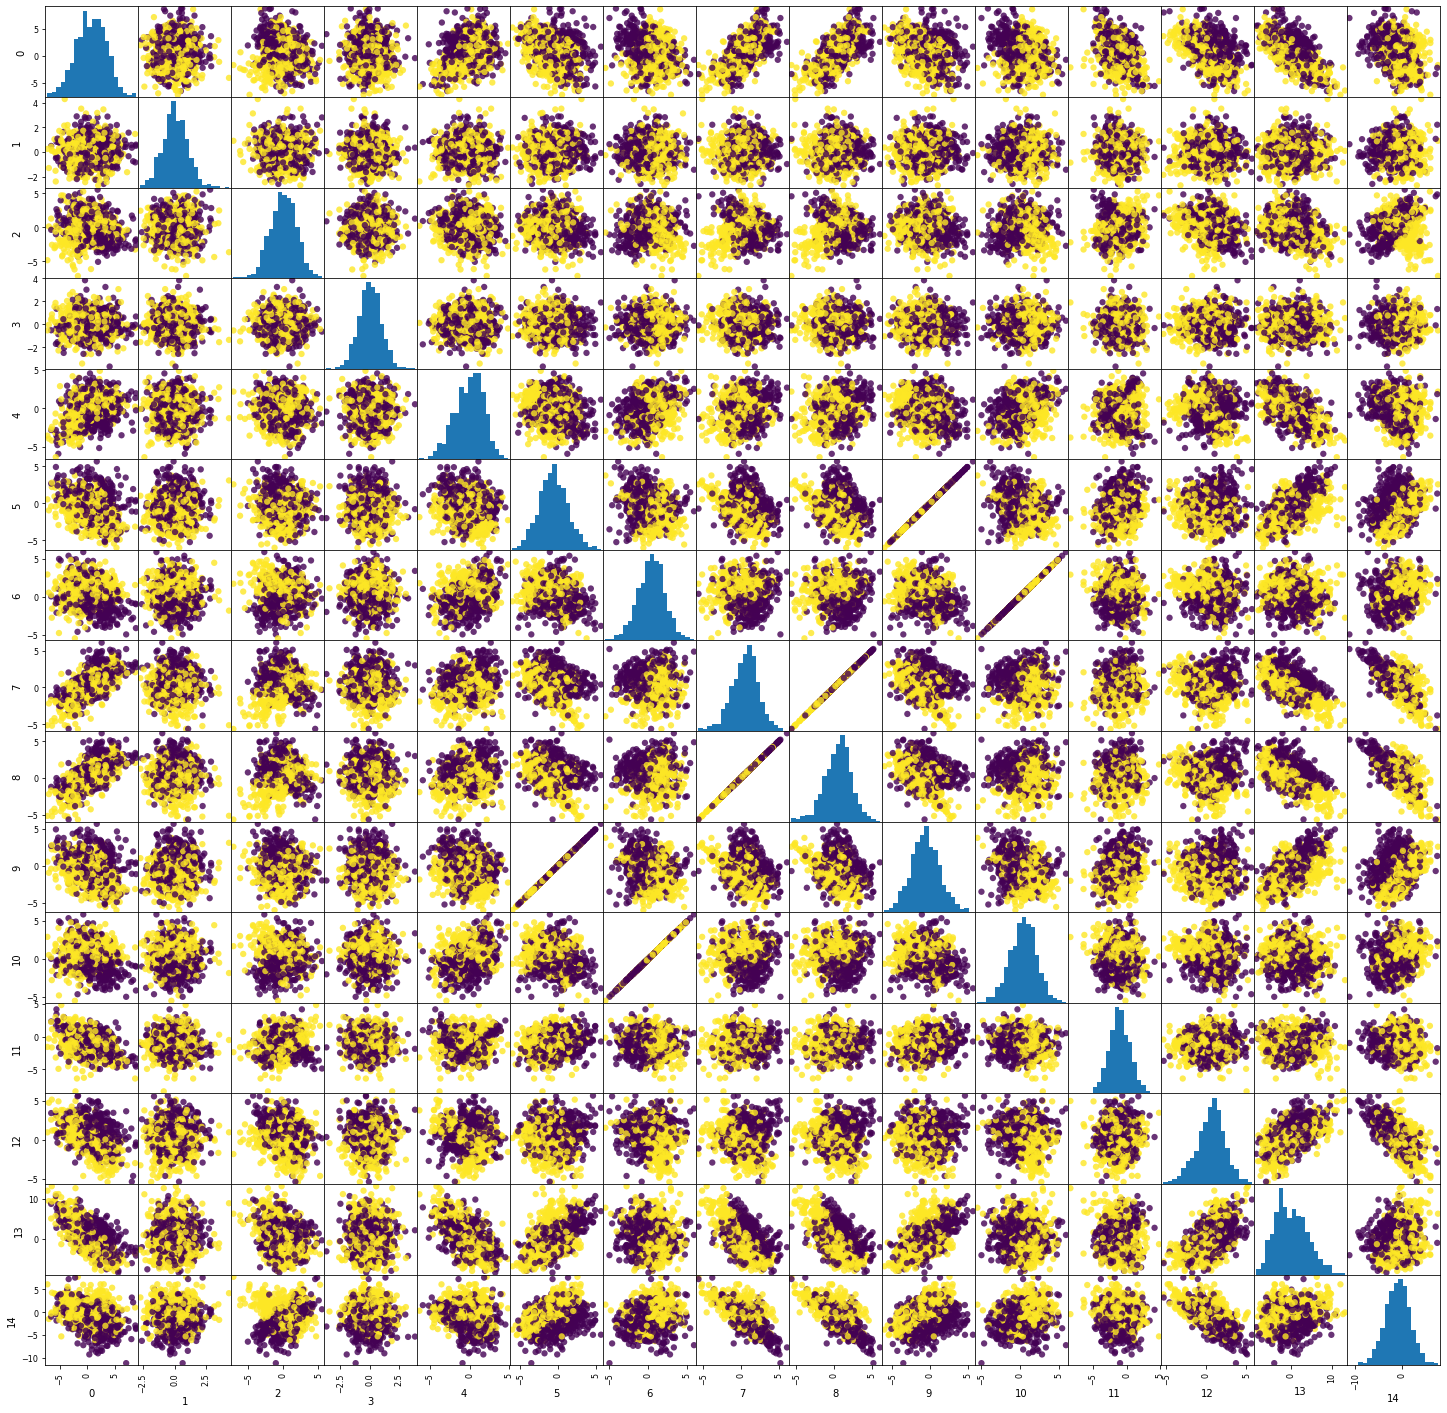

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

x, y = make_classification(n_samples=1000, n_features=15, n_informative=7, 
                           n_redundant=3, n_repeated=3, random_state=17)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=17)

features = pd.DataFrame(x)
targets = pd.Series(y)

scat_mtrx = pd.plotting.scatter_matrix(features, c=targets, figsize=(25, 25), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Теперь приступим к построению модели. В уроке мы разбирали алгоритм xgboost в интерфейсе библиотеки sklearn: для обучения использовали метод *fit* модели, а для предсказаний - *predict*.

Здесь будем использовать интерфейс библиотеки xgboost.

В этом интерфейсе для обучения XGBoost данные должны быть представлены в виде объекта DMatrix - внутренней структуры данных, используемой библиотекой  XGBoost, которая оптимизирована как по эффективности работы с памятью, так и по скорости обучения.

Также заранее определим параметры алгоритма:
- бинарная классификация - 'objective': 'binary:logistic'
- глубина деревьев - 'max_depth': 3
- шаг градиентного спуска (скорость обучения) - 'eta': 0.1
- количество итераций бустинга - num_rounds = 60

In [2]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 3,
          'eta': 0.1}

num_rounds = 60

### 1.
С помощью метода *train* библиотеки xgboost обучите модель. Передайте в метод вышеопределенные словарь параметров, тренировочные данные в формате DMatrix и число итераций.

In [3]:
xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds)

### 2.
В методе *train* есть параметр *evals* - список валидационных наборов данных, для которых будут оцениваться показатели во время обучения. Они помогут нам отслеживать качество модели для каждой итерации.

Создайте список из двух кортежей (dtest, 'test') и (dtrain, 'train'). Снова определите метод train аналогично предыдущему пункту, добавив этот список в качестве параметра.

In [4]:
evals = [(dtest, 'test'), (dtrain, 'train')]
xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=evals)

[0]	test-error:0.27667	train-error:0.19143
[1]	test-error:0.26000	train-error:0.19571
[2]	test-error:0.26000	train-error:0.19571
[3]	test-error:0.25667	train-error:0.19571
[4]	test-error:0.26333	train-error:0.19429
[5]	test-error:0.24333	train-error:0.18000
[6]	test-error:0.25000	train-error:0.18000
[7]	test-error:0.25000	train-error:0.16429
[8]	test-error:0.24333	train-error:0.15571
[9]	test-error:0.22333	train-error:0.15143
[10]	test-error:0.22333	train-error:0.14571
[11]	test-error:0.22000	train-error:0.14000
[12]	test-error:0.22000	train-error:0.13429
[13]	test-error:0.23333	train-error:0.13000
[14]	test-error:0.21333	train-error:0.12571
[15]	test-error:0.20667	train-error:0.12857
[16]	test-error:0.21333	train-error:0.12429
[17]	test-error:0.21333	train-error:0.11571
[18]	test-error:0.20667	train-error:0.11429
[19]	test-error:0.21333	train-error:0.11571
[20]	test-error:0.21333	train-error:0.11429
[21]	test-error:0.21667	train-error:0.11143
[22]	test-error:0.21667	train-error:0.1100

### 3.
В качестве метрики оценки важности признаков в XGBoost используется F-score, которая вычисляется на основе того, как часто делалось разбиение по данному признаку.

Используйте метод plot_importance библиотеки XGBoost. Передайте туда в качестве параметра xgb_model.

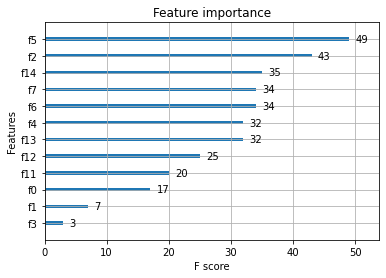

In [5]:
xgb.plot_importance(xgb_model)

По полученным данным можно посмотреть, какие признаки являются излишними и их можно убрать, а какие наиболее важны при обучении модели, т.е. используются чаще всего.

### Несбалансированные выборки

Мы уже упоминали о том, что работа с несбалансированными выборками несколько отличается от работы с идеальными датасетами. В XGBoost есть возможность несколько упростить эту работу: 
- задать большие веса некоторым объектам при инициализации DMatrix
- контролировать соотношение числа объектов разных классов с помощью параметра set_pos_weight

Сгенерируем несбалансированную выборку.

In [6]:
x, y = make_classification(n_samples=1000, n_features=7, n_informative=3, n_redundant=3, 
                           n_classes=2, weights=[.9, .1], random_state=20)

print(f'There are {sum(y)} positive instances')

There are 104 positive instances


### 4.
Разбейте выборку на тренировочную и тестовую, соблюдая стратификацию по *y* и размер тестового датасета 0.3. Создайте объекты DMatrix для тренировочной и тестовой выборок.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=20)
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

Зададим параметры для алгоритма и количество итераций.

In [9]:
params = {'objective': 'binary:logistic', 
          'max_depth': 1, 
          'eta': 1}

num_rounds = 30

### 5.
С помощью метода train обучите модель. С помощью метода predict получите предсказания для тестовых данных. Так как алгоритм возвращает вероятности, получите бинарную матрицу значений этих вероятностей, элементы которой при полученной вероятности > 0.5 равны True, а при вероятности <= 0.5 равны False. Выведите эту матрицу.

In [10]:
xgb_model = xgb.train(params, d_train, num_boost_round=num_rounds)
xgb_prediction = xgb_model.predict(d_test)
binary_matrix = xgb_prediction > 0.5
binary_matrix

array([False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### 6.
Выведите матрицу ошибок, точность и полноту для полученных предсказаний.

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [12]:
confusion_matrix(y_test, binary_matrix)

array([[257,   4],
       [ 18,  21]])

In [13]:
precision_score(y_test, binary_matrix)

0.84

In [14]:
recall_score(y_test, binary_matrix)

0.5384615384615384

Видно, что полнота гораздо ниже точности, т.е. алгоритм плохо распознает объекты класса, который представлен меньшим количеством экземпляров.

Теперь зададим вручную веса для экземпляров классов.

In [15]:
import numpy as np

weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

### 7.
Повторите то же, что делали ранее: создайте объекты DMatrix - для тренировочных данных укажите веса, а для тестовых оставьте только сами данные; обучите модель и получите ее предсказания так же, как и в предыдущем случае. Выведите матрицу ошибок, точность и полноту.

In [16]:
d_train = xgb.DMatrix(X_train, y_train, weight=weights)
d_test = xgb.DMatrix(X_test, y_test)

In [17]:
xgb_model = xgb.train(params, d_train, num_boost_round=num_rounds)
xgb_prediction = xgb_model.predict(d_test)
binary_matrix = xgb_prediction > 0.5

In [18]:
confusion_matrix(y_test, binary_matrix)

array([[247,  14],
       [ 11,  28]])

In [19]:
precision_score(y_test, binary_matrix)

0.6666666666666666

In [20]:
recall_score(y_test, binary_matrix)

0.717948717948718

Можем увидеть, что значение полноты увеличилось, но при этом точность уменьшилась. Если нам важны обе метрики, то пригодится параметр scale_pos_weight в XGBoost.

### 8.
Снова создайте объекты DMatrix, как в первом случае (без задания весов).

In [21]:
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)

### 9.
Инициализируйте параметр scale_pos_weight как соотношение числа объектов двух классов. Для этого число объектов класса 0 разделите на число объектов класса 1. Добавьте в словарь параметров алгоритма params пару с ключом 'scale_pos_weight' и значением, равным полученному соотношению классов.

In [22]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
params['scale_pos_weight'] = scale_pos_weight / 2.3
params

{'objective': 'binary:logistic',
 'max_depth': 1,
 'eta': 1,
 'scale_pos_weight': 4.247491638795987}

### 10.
Обучите модель с параметрами params и получите ее предсказания для тестовой выборки. Выведите матрицу ошибок, точность и полноту.**

In [23]:
xgb_model = xgb.train(params, d_train, num_boost_round=num_rounds)
xgb_prediction = xgb_model.predict(d_test)
binary_matrix = xgb_prediction > 0.5

In [24]:
confusion_matrix(y_test, binary_matrix)

array([[247,  14],
       [ 14,  25]])

In [25]:
precision_score(y_test, binary_matrix)

0.6410256410256411

In [26]:
recall_score(y_test, binary_matrix)

0.6410256410256411

Значение параметра scale_pos_weight надо выбирать в зависимости от желаемого соотношения между точностью и полнотой. Например, если нам нужны примерно одинаковые значения precision и recall, в данном случае следует уменьшить полученное значение параметра в несколько раз.

**В соответствии с предыдущим текстом значения `precision` и `recall` совпали при уменьшении `scale_pos_weight` в 2.3 раза (см. п. 9)**